In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.colors import TwoSlopeNorm
from celmech import Andoyer
import rebound
from celmech.andoyer import get_Xstarres, get_Xstarunstable, get_Xstarnonres, get_Xsep
import pdb
from statsmodels.stats.weightstats import DescrStatsW
import corner
from tqdm import tqdm
from celmech.andoyer import get_Hsep
import glob
import pandas as pd
import spock
from spock import FeatureClassifier
from statsmodels.stats.weightstats import DescrStatsW
from scipy import stats

In [2]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('text', usetex=True)
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
plt.rc('font', family='serif',size=20)
plt.rc('axes', linewidth=3.0)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20, direction='in')
plt.rc('ytick', labelsize=20, direction='in')
plt.rc('legend', fontsize=20)

# setting xtick parameters:

plt.rc('xtick.major',size=15,pad=8)
plt.rc('xtick.minor',size=10,pad=8)

plt.rc('ytick.major',size=15)
plt.rc('ytick.minor',size=10)

# Routines

In [3]:
# last TESS observation:
t_tess = 4664.65

# last K2 observation:
t_K2 = 2265

t = t_tess - t_K2

t_orbits = t/8.24958

#print('Number of orbits between observations: {:.0f}'.format(t_orbits))

t_orb = t_orbits*5.98
tmax = 1.0*t_orb
Nout = 200

t = np.linspace(0,tmax,Nout)
obs_tess = np.where(np.round(abs(t - t_orb),6) == np.round(np.min(abs(t - t_orb)),6))[0][0] 

delta_index = 0
obs_idx=[delta_index,obs_tess+delta_index] # [20, 519] in the current version

nobs = 2
obs_err = np.array([0.0001, 0.0005])
obs = np.array([1.503, 1.503]) 

def makesim(theta,dt=None):
    if dt==None:
        e_forced, e_free, mu, deltaT = theta
    else:
        e_forced, e_free, mu = theta[0], theta[1], theta[2]
        deltaT = dt
    mratio=0.5
    #e_com=float(np.random.uniform(0, 0.3, size=1)),  # varying between 0 and max(Z*) = 0.3
    e_com = 0.0
    phiecom=float(np.random.uniform(0, 2*np.pi, size=1)) # varying between 0 and 2pi
    #phiecom=0.0
    theta1 = np.pi
    #pomega_b=None
    
    Mstar = 1.1
    m1 = mratio*10**mu
    m2 = (1-mratio)*10**mu
    phi = np.pi # where equilibrium is
    theta1 = np.pi # so they start on opposite sides

    andvars = Andoyer.from_Z(j=3, k=1, Z=(e_forced+e_free)/np.sqrt(2), phi=phi, 
                             Zstar=e_forced/np.sqrt(2), Mstar=Mstar, m1=m1, m2=m2, 
                             Zcom=e_com/np.sqrt(2), phiZcom=phiecom, theta1=theta1)

    try:
        sim = andvars.to_Simulation()
        sim.integrator="whfast"
        sim.dt = sim.particles[1].P/20
        sim.ri_whfast.safe_mode = 0
        sim.integrate(deltaT)
        sim.t = 0
        return sim
    except:
        print(e_forced, e_free, deltaT, mu)
        raise
        
def run(sim):
    
    Pratios = np.zeros(Nout)
    ps = sim.particles

    for i, time in enumerate(t):
        
        sim.integrate(time)
        Pratios[i] = ps[2].P/ps[1].P
        
    return Pratios

def compute_model(theta):
    """
    Computes the model observation periods given a set of parameters at the observation indices
    """

    sim = makesim(theta)
    
    period_ratios = run(sim)

    return period_ratios[obs_idx]

def lnlike(theta):
    
    """
    Determines the gaussian log likelihood.
    obs: period ratio observations
    theta: parameters
    obs_err: errors in the shape of (obs,sample_size) for K2 and TESS
    """
    e_forced, e_free, mu, deltaT = theta
    
    #if e_forced < 5e-4 or e_forced > 0.20 or e_free < 5e-4 or e_free > 0.2 or mu < np.log10(3e-5) or mu > -3:
    #    return -np.inf
    
    #else:
    
    model = compute_model(theta)
    #print(model)
    argument = (obs - model)**2 / obs_err**2

    loglike = 0.5*np.sum(argument)
    return loglike

## Corner Plot Function

In [4]:
def corner_plot(res_arr, preds_arr, sigma_limits, labels, weighted=True,pl_b=False,ecc_b=False, pl_e=False, ecc_e=False):
     
    if pl_b:
        ndim = np.shape(res_arr)[1]
    else:
        ndim = 3
    
    plt.rcParams['figure.facecolor'] = 'white'
    fig = corner.corner(
        np.array(res_arr), labels=labels,plot_contours=False, plot_density=False,#quantiles=[0.95],
        hist_kwargs={'color':'k','density':True,'zorder': 1},       
        plot_datapoints=False,
        weights=preds_arr
    )

    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i,yi in enumerate(range(ndim)):
        
        for xi in range(yi):
            ax = axes[yi, xi]
             
            ax.scatter(np.array(res_arr)[:,xi][preds_arr!=0.0], np.array(res_arr)[:,yi][preds_arr!=0.0],
                       color="k", alpha=preds_arr[np.where(preds_arr != 0.0)], s=0.1,zorder=1)
            ax.scatter(np.array(res_arr)[:,xi][preds_arr==0.0], np.array(res_arr)[:,yi][preds_arr==0.0], 
                       color="r", 
                       alpha=0.1, s=0.1,zorder=0)
            
            #if xi==2:
            #    ax.set_xscale('log')
            #if yi==2:
            #    muaxis = ax.scatter(np.array(res_arr)[:,xi][preds_arr!=0.0], 
            #                        np.array(res_arr)[:,yi][preds_arr!=0.0],
            #           color="k", alpha=preds_arr[np.where(preds_arr != 0.0)], s=0.1,zorder=1)
                #ax.set_yscale('log')
            #if yi==2 and i==2:
            #    muaxis2 = ax.scatter(np.array(res_arr)[:,xi][preds_arr!=0.0], 
            #                        np.array(res_arr)[:,yi][preds_arr!=0.0],
            #           color="k", alpha=preds_arr[np.where(preds_arr != 0.0)], s=0.1,zorder=1)
            #    muaxis2.set_yscale('log')
            #    muaxis2.set_yticklabels([])

       

    
    if weighted==True:
        for i in range(ndim):
            ax = axes[i, i]
            ax.hist(np.array(res_arr)[:,i], color="C1", histtype='step',density=True, zorder=0)
            ax.set_title(labels[i]+" $ \\leq {0:.2g}$".format(sigma_limits[i]), fontsize=15)
            ax.axvline(x=sigma_limits[i], ls='--',color='k')
            
            if pl_b:
                if i == 3:
                    ax.axvline(x=m_b_2sigma_rv, ls='--',color='g')
                    #ax.axvspan(-6.5, m_b_2sigma_rv, alpha=0.05, color='g')

                    ax.axvline(x=sigma_limits[3], ls='--',color='k')
                    #ax.axvspan(-6.5, sigma_limits[3], alpha=0.05, color='k')

                if ecc_b:
                    if i == 4:
                        ax.axvline(x=e_b_2sigma_rv, ls='--',color='g')
                        #ax.axvspan(0.0, e_b_2sigma_rv, alpha=0.05, color='g')

                        ax.axvline(x=sigma_limits[4], ls='--',color='k')
                        #ax.axvspan(0.0, sigma_limits[4], alpha=0.05, color='k')
    
    plt.show()

## Phinorm and Delta H Function

In [5]:
def get_Phinorm(post_array):
    np.random.seed(0)
    phi, Phinorm = np.zeros(len(post_array)), np.zeros(len(post_array))
    # see separatrix note on Dan's ipad
    for i, p in tqdm(enumerate(post_array)):
        sim = makesim(p, dt=0)
        andvars = Andoyer.from_Simulation(sim, j=j, k=k)
        Phiprime = andvars.Phiprime
        Xstarres = get_Xstarres(k, Phiprime)
        Xsep_inner, Xsep_outer = get_Xsep(k, Phiprime)
        Phistarres = Xstarres**2/2
        Phisep_outer = Xsep_outer**2/2
        sim = makesim(p, dt=np.random.random()*2000)
        andvars = Andoyer.from_Simulation(sim, j=j, k=k)
        Phinorm[i] = (andvars.Phi-Phistarres)/(Phisep_outer - Phistarres)
        phi[i] = andvars.phi
        
    return phi, Phinorm

def get_H(andvars):
    X = andvars.X
    Y = andvars.Y
    k = andvars.params['k']
    Phiprime = andvars.Phiprime
    H = (X**2 + Y**2)**2 - 3*Phiprime/2*(X**2+Y**2)+(X**2+Y**2)**((k-1)/2)*X 
    return H


def get_deltaH(post_array, j, k, i1, i2, pl_b=True):

    #j1 = 3
    #j2 = 2
    #k = 1

    deltaH = []

    for i,param in tqdm(enumerate(post_array)):
        sim = makesim(param[:4],dt=0)
        
        if pl_b:
            m_b = 10**param[-2]
            e_b = param[-1]

            pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
            sim.add(m=m_b, P=sim.particles[2].P*1.946, e=e_b, pomega=pomega_b, theta=np.pi/2)
        
        #if both:
        andvars = Andoyer.from_Simulation(sim, j=j, k=k, i1=i1, i2=i2)

        H = get_H(andvars)
        Hsep = get_Hsep(k, andvars.Phiprime)

        deltaH.append(H-Hsep)
        
    return deltaH

## Stability Sampler Function

In [162]:
def sampler(nsamples, post_array, bmass_lims=[8.964e-6, 3e-3],e_b=False, pl_e=False, e_e=False, rv_params=False):
    
    sim_list = []
    indices = []
    
    seeds = np.arange(0, nsamples)
    
    pbar = tqdm(total=nsamples)
   # i = 0
    while len(sim_list) < nsamples:
        
        #np.random.seed(seed=seeds[i])
        if rv_params:
            # Mascareño et al. (2021) values:

            m_b = float(stats.norm.rvs(loc=0.64, scale=0.19))*1e-3

            if e_b:
                e_b = float(stats.norm.rvs(loc=0.13, scale=0.07))
            #elif e_b_flat:
            #    e_b = float(np.random.uniform(0, 0.3, size=1))  
            else: 
                e_b = 0.0

            if m_b < 0 or e_b < 0.0:
                    continue
            if pl_e:
                m_e = float(stats.norm.rvs(loc=1.16, scale=0.3))*1e-3
                e_e = float(stats.norm.rvs(loc=0.1, scale=0.09))
                P_e = float(stats.norm.rvs(loc=50.29, scale=6.62))

                if m_e < 0 or e_e < 0.0 or P_e < 0.0:
                    continue
        else:
        # Wide values:
            m_b = float(stats.loguniform.rvs(float(bmass_lims[0]), float(bmass_lims[1]), size=1))

            if e_b:
                e_b = float(np.random.uniform(0, 0.3, size=1))  
            else: 
                e_b = 0.0
            
            if m_b < 0 or e_b < 0.0:
                    continue
                
            if pl_e:
                m_e = float(stats.loguniform.rvs(3e-5, 3e-3, size=1))
                #P_e = float(stats.norm.rvs(loc=50.29, scale=6.62))
                P_e = float(np.random.uniform(40, 70, size=1)) 
                
                if e_e:
                    e_e = float(np.random.uniform(0, 0.3, size=1))
                else:
                    e_e = 0.0
                
                if m_e < 0 or e_e < 0.0 or P_e < 0.0:
                    continue

        # selecting random sample from the MLE posteriors:
        ind = int(np.random.randint(0, len(post_array), size=1))
        sim = makesim(post_array[ind])
        
        pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
        sim.add(m=m_b, P=sim.particles[2].P*1.946, e=e_b, pomega=pomega_b, theta=np.pi/2)
        
        if pl_e:
            pomega_e = float(np.random.uniform(0, 2*np.pi, size=1))
            pl_e_period = P_e/sim.particles[3].P
            sim.add(m=m_e, P=pl_e_period, e=e_e, pomega=pomega_e, theta=np.pi/2)
            
        sim.move_to_com()

        sim_list.append(sim)
        indices.append(ind) # important to keep for later
        
       # i += 1

        pbar.update()
    pbar.close()
    
    return sim_list, indices
            
def spock_pred(simlist):
    model = FeatureClassifier()
    return model.predict_stable(simlist)

def weighted_results(sims, indices, sigma, post_array, ecc_b=False, pl_e=False, ecc_e=False):
    pred = spock_pred(sims)
    
    # planet b posteriors
    M_b = [np.log10(s.particles[-1].m) for s in sims]
    e_b = [s.particles[-1].e for s in sims]
        
    
    if pl_e:
        
        M_b = [np.log10(s.particles[-2].m) for s in sims]
        e_b = [s.particles[-2].e for s in sims]
        
        P_e = [s.particles[-1].P*s.particles[-2].P  for s in sims]
        M_e = [np.log10(s.particles[-1].m) for s in sims]
        e_e = [s.particles[-1].e for s in sims]
        
    
    s = np.array(post_array)[indices]

    s_results = []
    for i,r in enumerate(s):
        p = list(r)
        p.append(M_b[i])
        if ecc_b:
            p.append(e_b[i])
        if pl_e:
            p.append(P_e[i])
            p.append(M_e[i])
            if ecc_e:
                p.append(e_e[i])
        s_results.append(p)
        
    for j in s_results:
        del j[3]
    # calculating upper bounds using the SPOCK probabilities as weights
    sigma_list = [float(DescrStatsW(data=np.array(s_results)[:,i], 
                         weights=pred).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in range(np.shape(s_results)[1])]
    
    return s_results, pred, sigma_list

# Reading Rejection Posteriors

We begin by reading the rejection posteriors and by quantifying how much $\mu$ changes by inserting planet b's parameters. Early results showed that it affected $\mu$, but not by much. How do the lower bounds on planet b shape $\mu$? The answer that this section shows is that our chosen priors to report on are the most conservative.

## Plotting original rejection posterior of $\mu$: $\log{(\mathcal{U})} \sim (3 M_\oplus, 1 M_\rm{Jup})$

In [142]:
path = '/Users/Helios/gdrive_pu/tamayo_research/lnlike_60mil/'
params = [np.load(file, allow_pickle=True) for file in glob.iglob(path+'/*.npy', recursive=True)]

par_con = np.concatenate(params)
print(len(par_con))

like_output = par_con[pd.notnull(par_con)]

print(len(like_output))

params = [list(like_output[i][:2]) for i in range(len(like_output))]
#mus = [np.log10((10**like_output[i][-1])/9.54e-4) for i in range(len(like_output))]
mus = [like_output[i][-1] for i in range(len(like_output))]
deltaTs = [like_output[i][2] for i in range(len(like_output))]

like_output = []

for p,mu,T in zip(params,mus,deltaTs):
    r = list(p)
    r.append(mu)
    r.append(T)
    
    like_output.append(r)

61700000
9693


In [143]:
#np.save('/Users/Helios/spock_V1298tau/rejection_sampling_posteriors/batches_3Mearth_1Mjup_c_d_60mil.npy', 
#        like_output)

In [144]:
like_output[0]

[0.020046482980082072,
 0.01733623062960902,
 -4.58538010333303,
 455.35669596941085]

In [145]:
like_output_list = [list(s) for s in like_output]

for j in like_output_list:
    del j[-1]

In [146]:
sigma=0.997
sigma_list = [float(DescrStatsW(data=np.array(like_output_list)[:,i]).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in range(np.shape(like_output_list)[1])]

In [10]:
# before with only 30 mil
(10**sigma_list[2])/9.46e-4

0.7723244768849301

In [147]:
(10**sigma_list[2])/9.46e-4

0.7206144407363333

## Res vs. non-res for original rejection posterior

In [148]:
deltaH_cd_likepost = get_deltaH(like_output,j=3, k=1, i1=1, i2=2, pl_b=False)

9693it [01:37, 99.46it/s] 


In [13]:
inres = np.array(like_output)[np.array(deltaH_cd_likepost) < 0.0] 
outres = np.array(like_output)[(np.array(deltaH_cd_likepost) >= 0.0) | np.isnan(np.array(deltaH_cd_likepost))]

print(len(inres))
print(len(outres))

945
3662


In [149]:
# with 60 mil:
inres = np.array(like_output)[np.array(deltaH_cd_likepost) < 0.0] 
outres = np.array(like_output)[(np.array(deltaH_cd_likepost) >= 0.0) | np.isnan(np.array(deltaH_cd_likepost))]

print(len(inres))
print(len(outres))

2050
7643


In [150]:
inres_list = [list(s) for s in inres]

for j in inres_list:
    del j[-1]

outres_list = [list(s) for s in outres]

for j in outres_list:
    del j[-1]

In [151]:
inres_list[0]

[0.08234013813525742, 0.0031775534131933654, -4.948543730827809]

In [152]:
sigma=0.997
threesig_inres = [float(DescrStatsW(data=np.array(inres_list)[:,i]).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in \
              range(np.shape(inres_list)[1])]
threesig_outres = [float(DescrStatsW(data=np.array(outres_list)[:,i]).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in \
              range(np.shape(outres_list)[1])]

In [153]:
print(threesig_inres)
print('\n')
print(threesig_outres)

[0.1858439871507199, 0.02853087937539518, -3.0637655642668418]


[0.08506063050748101, 0.0237195967302758, -3.194131133580813]


In [154]:
print((10**(threesig_inres[-1]))/9.54e-4)
print((10**(threesig_outres[-1]))/9.54e-4)

0.9050781094760085
0.6703791395406516


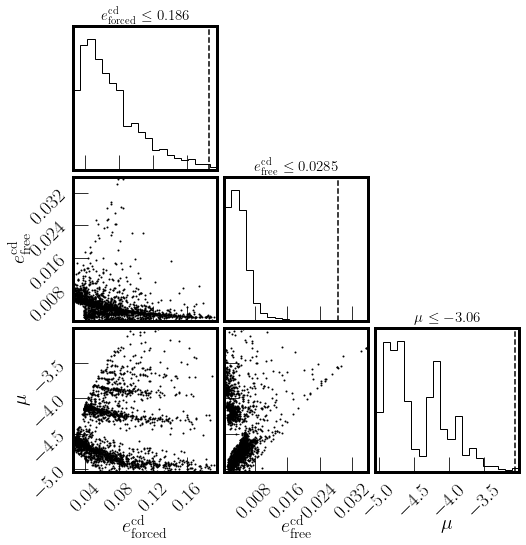

In [155]:
%matplotlib inline
ndim = np.shape(inres_list)[1]
#labels=["$Z_\star$", "$z_f$", "$\mu$ [$\log{\\rm{M}_{\\rm{Jup}}}$]"]
labels=["$e_{\\rm{forced}}^{\\rm{cd}}$", "$e_{\\rm{free}}^{\\rm{cd}}$", "$\mu$"]
plt.rcParams['figure.facecolor'] = 'white'
fig = corner.corner(
    np.array(inres_list), labels=labels,plot_contours=False, plot_density=False,#quantiles=[0.95],
    hist_kwargs={'density':True},       
    plot_datapoints=False,
    #weights=preds_arr
)

axes = np.array(fig.axes).reshape((ndim, ndim))
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.scatter(np.array(inres_list)[:,xi], np.array(inres_list)[:,yi], s=1,
                   color="k", alpha=1.0#*preds_arr[np.where(preds_arr != 0.0)], s=1
                  )
        #ax.scatter(np.array(res_arr)[:,xi][preds_arr==0.0], np.array(res_arr)[:,yi][preds_arr==0.0], 
        #           color="C1", 
        #           alpha=0.05, s=1)
        #if yi==2:
        #    ax.set_yscale('log')
            
        #if xi==2 and yi==2:
        #    ax.set_yticklabels([])

#axes[2,2].set_yticklabels([])

for i in range(ndim):
    ax = axes[i, i]
    #ax.hist(np.array(priors)[:,i], color="C1", histtype='step',density=True)
    ax.set_title(labels[i]+" $ \\leq {0:.3g}$".format(threesig_inres[i]), fontsize=15)
    ax.axvline(x=threesig_inres[i], ls='--',color='k')
#plt.savefig('figures/Figure2b.pdf',dpi=300,bbox_inches='tight',padding=0)

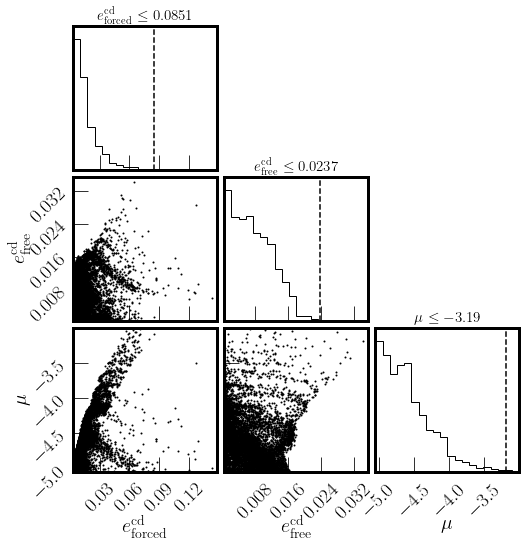

In [156]:
ndim = np.shape(outres_list)[1]
#labels=["$Z_\star$", "$z_f$", "$\mu$ [$\log{\\rm{M}_{\\rm{Jup}}}$]"]
labels=["$e_{\\rm{forced}}^{\\rm{cd}}$", "$e_{\\rm{free}}^{\\rm{cd}}$", "$\mu$"]
plt.rcParams['figure.facecolor'] = 'white'
fig = corner.corner(
    np.array(outres_list), labels=labels,plot_contours=False, plot_density=False,#quantiles=[0.95],
    hist_kwargs={'density':True},       
    plot_datapoints=False,
    #weights=preds_arr
)

axes = np.array(fig.axes).reshape((ndim, ndim))
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.scatter(np.array(outres_list)[:,xi], np.array(outres_list)[:,yi], s=1,
                   color="k", alpha=1.0#*preds_arr[np.where(preds_arr != 0.0)], s=1
                  )
        #ax.scatter(np.array(res_arr)[:,xi][preds_arr==0.0], np.array(res_arr)[:,yi][preds_arr==0.0], 
        #           color="C1", 
        #           alpha=0.05, s=1)
        #if yi==2:
        #    ax.set_yscale('log')
            
        #if xi==2 and yi==2:
        #    ax.set_yticklabels([])

#axes[2,2].set_yticklabels([])

for i in range(ndim):
    ax = axes[i, i]
    #ax.hist(np.array(priors)[:,i], color="C1", histtype='step',density=True)
    ax.set_title(labels[i]+" $ \\leq {0:.3g}$".format(threesig_outres[i]), fontsize=15)
    ax.axvline(x=threesig_outres[i], ls='--',color='k')
#plt.savefig('figures/Figure2b.pdf',dpi=300,bbox_inches='tight',padding=0)

100it [00:01, 54.90it/s]


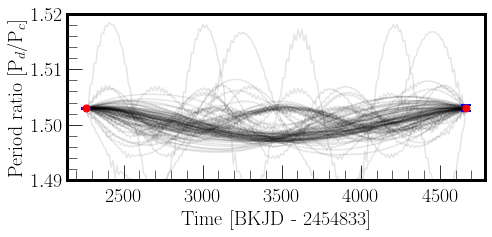

In [157]:
fig = plt.figure(1,figsize=(2.2*3.4, 1.2*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

for i,param in tqdm(enumerate(inres[:100])):
    p = param
    
    sim = makesim(p)
    #pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
    
    #sim.add(m=10**param[-2], P=sim.particles[2].P*1.946, e=param[-1], pomega=pomega_b, theta=np.pi/2)
    period_ratios = run(sim)
    
    ax.plot(time_grid,period_ratios,
         alpha=0.1,zorder=0, c='k',
         rasterized=True)

#ax1.plot(time_grid, run(makesim(min_mu[0][:4])), c='C2')

ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=7, c='r',ecolor='b',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_d$/P$_c$]',fontsize=20)
ax.set_ylim(1.49, 1.520)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=20)

ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

ax.minorticks_on()
plt.show()

100it [00:01, 57.59it/s]


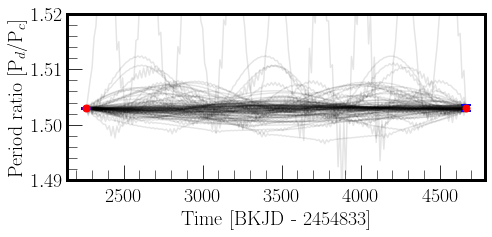

In [159]:
fig = plt.figure(1,figsize=(2.2*3.4, 1.2*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

for i,param in tqdm(enumerate(outres[:100])):
    p = param
    
    sim = makesim(p)
    #pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
    
    #sim.add(m=10**param[-2], P=sim.particles[2].P*1.946, e=param[-1], pomega=pomega_b, theta=np.pi/2)
    period_ratios = run(sim)
    
    ax.plot(time_grid,period_ratios,
         alpha=0.1,zorder=0, c='k',
         rasterized=True)

#ax1.plot(time_grid, run(makesim(min_mu[0][:4])), c='C2')

ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=7, c='r',ecolor='b',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_d$/P$_c$]',fontsize=20)
ax.set_ylim(1.49, 1.520)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=20)

ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

ax.minorticks_on()
plt.show()

## Prior sensitivity on $\mu$: $\log{(\mathcal{U})} \sim (10 M_\oplus, 1 M_\rm{Jup})$

In [12]:
path2 = '/Users/Helios/spock_V1298tau/rejection_sampling_posteriors/batches_10Mearth_1Mjup_c_d_30mil/'
params2 = [np.load(file, allow_pickle=True) for file in glob.iglob(path2+'/*.npy', recursive=True)]


par_con2 = np.concatenate(params2)

like_output2 = par_con2[pd.notnull(par_con2)]

print(len(like_output2))

params2 = [list(like_output2[i][:2]) for i in range(len(like_output2))]
mus2 = [np.log10((10**like_output2[i][-1])/9.54e-4) for i in range(len(like_output2))]
deltaTs2 = [like_output2[i][2] for i in range(len(like_output2))]

like_output2 = []

for p,mu,T in zip(params2,mus2,deltaTs2):
    r = list(p) 
    r.append(mu)
    r.append(T)
    
    like_output2.append(r)

2331


In [13]:
np.save('/Users/Helios/spock_V1298tau/rejection_sampling_posteriors/batches_10Mearth_1Mjup_c_d_30mil.npy', 
        like_output2)

In [ ]:
like_output2[0]

In [203]:
like_output_list2 = [list(s) for s in like_output2]

for j in like_output_list2:
    del j[-1]

In [204]:
sigma=0.997
two_sigma = [float(DescrStatsW(data=np.array(like_output_list2)[:,i]).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in range(np.shape(like_output_list2)[1])]

In [209]:
(10**two_sigma[2])

0.9002031095811793

Note: $\mu$ is in log of jupiter masses!! So 0 is 1 Mjup below.

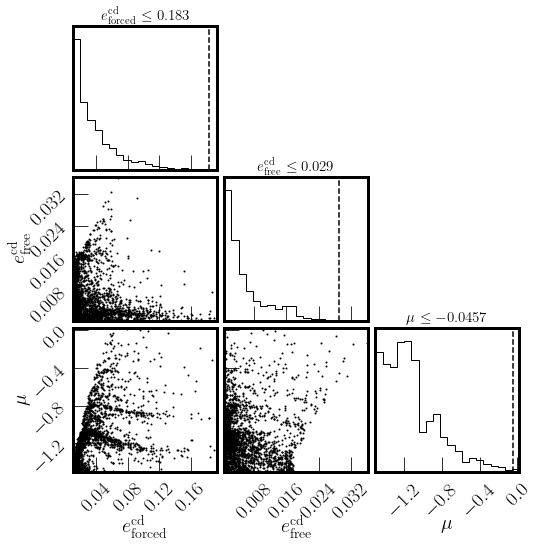

In [214]:
ndim = np.shape(like_output_list)[1]
#labels=["$Z_\star$", "$z_f$", "$\mu$ [$\log{\\rm{M}_{\\rm{Jup}}}$]"]
labels=["$e_{\\rm{forced}}^{\\rm{cd}}$", "$e_{\\rm{free}}^{\\rm{cd}}$", "$\mu$"]
plt.rcParams['figure.facecolor'] = 'white'
fig = corner.corner(
    np.array(like_output_list2), labels=labels,plot_contours=False, plot_density=False,#quantiles=[0.95],
    hist_kwargs={'density':True},       
    plot_datapoints=False
    #weights=preds_arr
)

axes = np.array(fig.axes).reshape((ndim, ndim))
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.scatter(np.array(like_output_list2)[:,xi], np.array(like_output_list2)[:,yi], s=1,
                   color="k", alpha=1.0#*preds_arr[np.where(preds_arr != 0.0)], s=1
                  )
        #ax.scatter(np.array(res_arr)[:,xi][preds_arr==0.0], np.array(res_arr)[:,yi][preds_arr==0.0], 
        #           color="C1", 
        #           alpha=0.05, s=1)
        #if yi==2:
        #    ax.set_yscale('log')
            
        #if xi==2 and yi==2:
        #    ax.set_yticklabels([])

#axes[2,2].set_yticklabels([])

for i in range(ndim):
    ax = axes[i, i]
    #ax.hist(np.array(priors)[:,i], color="C1", histtype='step',density=True)
    ax.set_title(labels[i]+" $ \\leq {0:.3g}$".format(two_sigma[i]), fontsize=15)
    ax.axvline(x=two_sigma[i], ls='--',color='k')

## RV Sampling: $m_b \sim \mathcal{N(0.64, 0.19)},\ e \sim \mathcal{U}(0, 0.3)$

In [174]:
Nsamps = 100000

In [175]:
m_b_2sigma_rv = np.log10((0.64+3*0.19)*1e-3)
e_b_2sigma_rv = 0.13+3*0.07

In [176]:
simlist_logu, indices_logu = sampler(Nsamps, like_output, e_b=True)

100%|██████████| 100000/100000 [12:34<00:00, 132.52it/s]


In [177]:
s_results_logu, preds_logu, sigma_list_logu = weighted_results(simlist_logu,
                                                               indices_logu, 0.997, like_output, ecc_b=True)

In [178]:
#three_sigma = [float(DescrStatsW(data=np.array(s_results_rv)[:,i], 
#                         weights=preds_rv).quantile(probs=np.array([0.997]), 
#                                                 return_pandas=False)) for i in range(np.shape(s_results_rv)[1])]

In [179]:
sigma_list[2]

-3.16640590269028

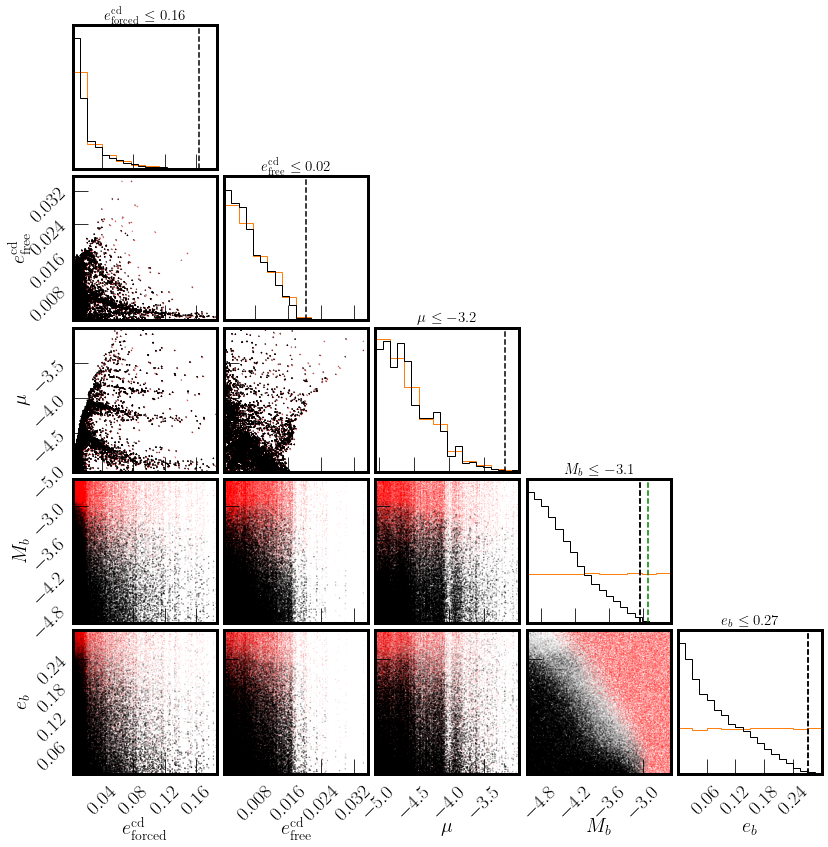

In [57]:
corner_plot(s_results_logu, preds_logu, sigma_list_logu, pl_b=True, ecc_b=True,
            labels=["$e_{\\rm{forced}}^{\\rm{cd}}$", "$e_{\\rm{free}}^{\\rm{cd}}$", "$\mu$", "$M_b$", "$e_b$"], 
           )

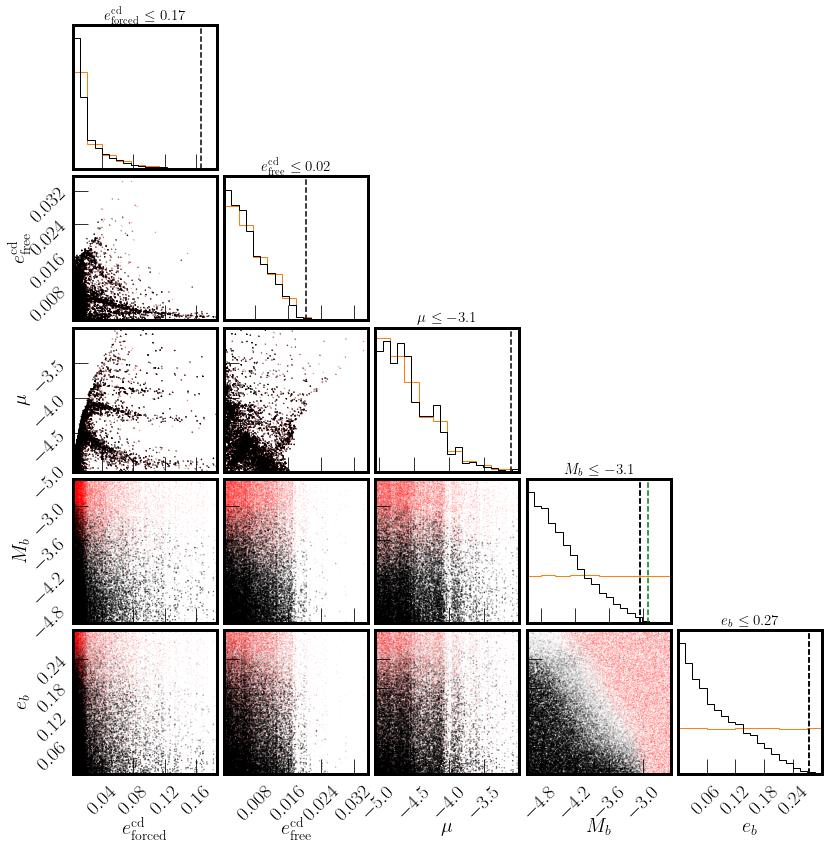

In [131]:
corner_plot(s_results_logu, preds_logu, sigma_list_logu, pl_b=True, ecc_b=True,
            labels=["$e_{\\rm{forced}}^{\\rm{cd}}$", "$e_{\\rm{free}}^{\\rm{cd}}$", "$\mu$", "$M_b$", "$e_b$"], 
           )

## RV Sampling: $m_b \sim \mathcal{N(0.64, 0.19)},\ e \sim \mathcal{N}(0.13, 0.07)$

In [160]:
Nsamps=100000

In [163]:
np.random.seed(42)
simlist_rv, indices_rv = sampler(Nsamps, like_output, e_b=True, rv_params=True)

100%|██████████| 100000/100000 [12:58<00:00, 128.44it/s]


In [164]:
%timeit
s_results_rv, preds_rv, sigma_list_rv = weighted_results(simlist_rv, 
                                                            indices_rv, 0.997, like_output, ecc_b=True)

In [ ]:
#np.save('stability_posteriors/100k_rv_stability_preds.npy',preds_rv)

In [165]:
#three_sigma = [float(DescrStatsW(data=np.array(s_results_rv2)[:,i], 
#                         weights=preds_rv2).quantile(probs=np.array([0.997]), 
#                                                 return_pandas=False)) for i in range(np.shape(s_results_rv2)[1])]

In [166]:
print('Our $3\sigma$:', sigma_list_rv[-1])
print('Mascareno+2021 RV:', 0.13+3*0.07)

print('Our $3\sigma$:', (10**sigma_list_rv[-2])/9.54e-4)
print('Mascareno+2021 RV:', 0.64+3*0.19)

Our $3\sigma$: 0.1827834918753552
Mascareno+2021 RV: 0.34
Our $3\sigma$: 1.06214123194921
Mascareno+2021 RV: 1.21


In [167]:
print('Our $3\sigma$:', three_sigma[-1])
print('Mascareno+2021 RV:', 0.13+3*0.07)

print('Our $3\sigma$:', (10**three_sigma[-2])/9.54e-4)
print('Mascareno+2021 RV:', 0.64+3*0.19)

Our $3\sigma$: 0.19037786392943545
Mascareno+2021 RV: 0.34
Our $3\sigma$: 1.0702652148568066
Mascareno+2021 RV: 1.21


In [34]:
s_results_rv2[0]

[0.006155671551264279,
 0.0031576017471837956,
 -4.771058871268219,
 -3.134081708545075,
 0.12032149891801737]

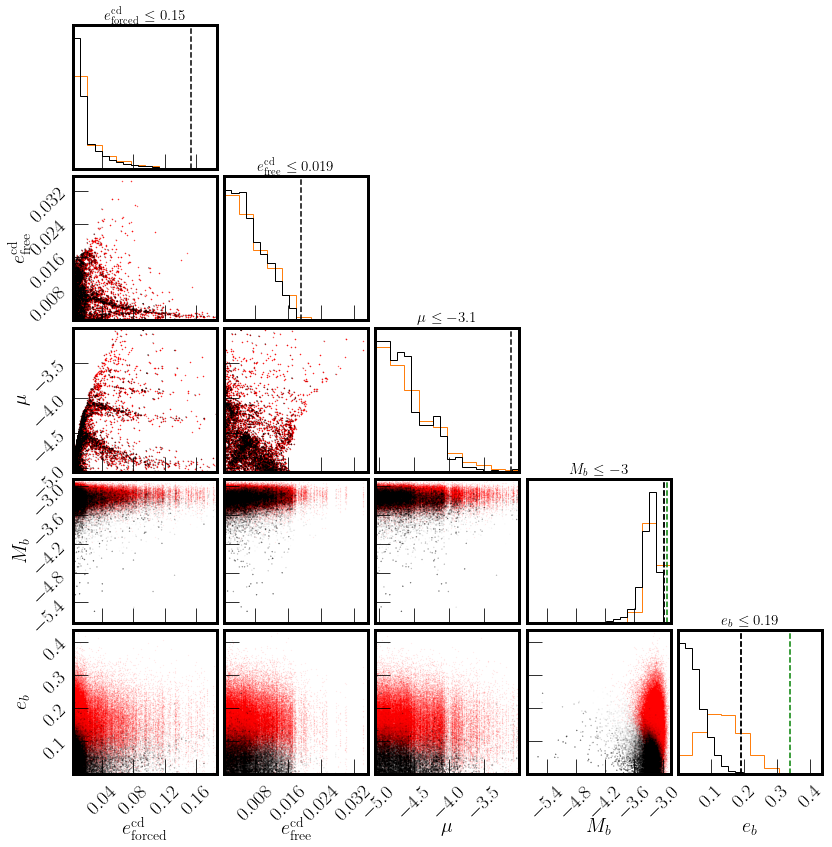

In [45]:
%matplotlib inline
corner_plot(s_results_rv2, preds_rv2, sigma_list_rv2, pl_b=True, ecc_b=True,
            labels=["$e_{\\rm{forced}}^{\\rm{cd}}$", "$e_{\\rm{free}}^{\\rm{cd}}$", "$\mu$", "$M_b$", "$e_b$"], 
           )

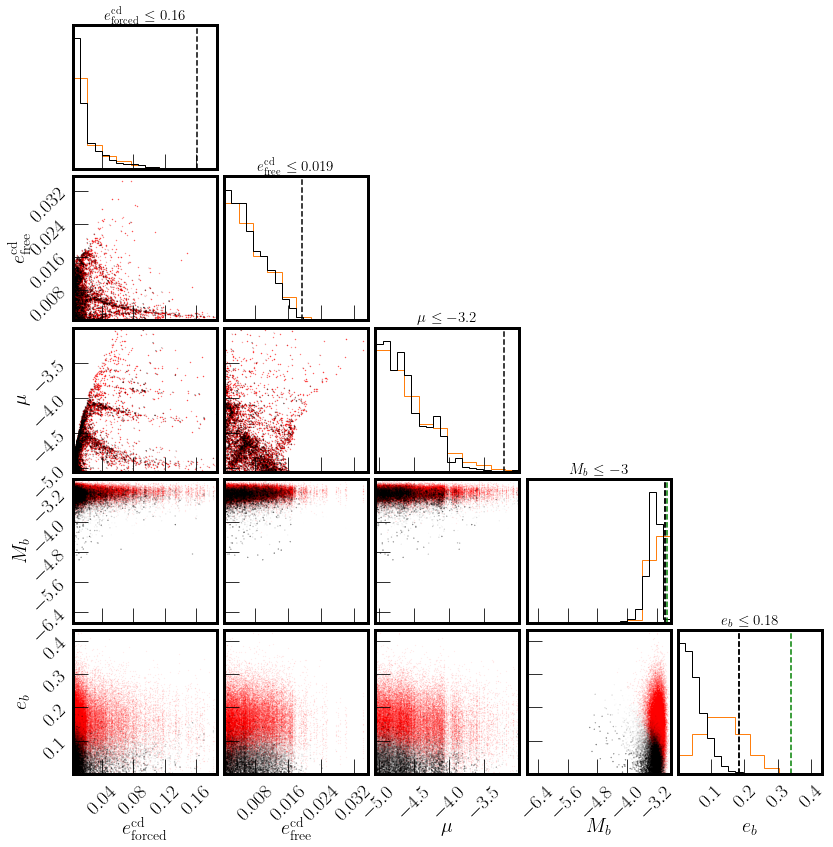

In [236]:
%matplotlib inline
corner_plot(s_results_rv2, preds_rv2, sigma_list_rv2, pl_b=True, ecc_b=True,
            labels=["$e_{\\rm{forced}}^{\\rm{cd}}$", "$e_{\\rm{free}}^{\\rm{cd}}$", "$\mu$", "$M_b$", "$e_b$"], 
           )

[0.021006538339974883,
 0.011685504559996862,
 -4.881361183404963,
 -3.2797449661636295,
 0.13630107928246632]

In [168]:
def sres_2_post(like_post, s_res, indices):
    """ 
    This function exists to fix past mistakes, so ignore if you can.
    """ 
    
    deltaTs = [np.array(like_post)[indices][i][-1] for i in tqdm(range(len(np.array(like_post)[indices])))]
    
    post_res = []
    
    for i,param in enumerate(s_res):
        deltaT = deltaTs[i]
        res_params = param[:3]
        res_params.append(deltaT)

        post_res.append(res_params)
        
    mb_array = np.array([s_res[i][-2] for i in range(len(s_res))])
    eb_array = np.array([s_res[i][-1] for i in range(len(s_res))])
        
    post = np.c_[post_res,mb_array,eb_array]
        
    return post

### MMR space

In [170]:
rv_post = sres_2_post(like_output, s_results_rv, indices_rv)

100%|██████████| 100000/100000 [38:49<00:00, 42.93it/s] 


In [186]:
logu_post = sres_2_post(like_output, s_results_logu, indices_logu)

100%|██████████| 100000/100000 [59:59<00:00, 27.78it/s]   


In [47]:
rv_post2[0]

array([ 6.15567155e-03,  3.15760175e-03, -4.77105887e+00,  9.79066001e+02,
       -3.13408171e+00,  1.20321499e-01])

In [187]:
#np.save('stability_posteriors/100k_rv_priors_100mil_lnlike.npy',rv_post)
np.save('stability_posteriors/100k_logu_priors.npy', logu_post)

In [29]:
# reading saved file... takes many hours to resample
rv_post = np.load('stability_posteriors/100k_rv_priors_100mil_lnlike.npy')

spock_prob_rv = np.load('stability_posteriors/100k_rv_stability_preds_100mil.npy')

In [188]:
# both should be 100k
print(len(rv_post))
print(len(spock_prob_rv))

100000
100000


In [172]:
# c--d 3:2 resonance
deltaH_cd_rv2 = get_deltaH(rv_post,j=3, k=1, i1=1, i2=2)

0it [00:00, ?it/s]/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:52: UserWarning: k=1 resonance has no unstable fixed point for Phiprime < 1
  warnings.warn("k=1 resonance has no unstable fixed point for Phiprime < 1")
/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:91: UserWarning: There is no separatrix for the passed value of Phiprime
  warnings.warn("There is no separatrix for the passed value of Phiprime")
100000it [17:25, 95.63it/s]


In [173]:
# d--b 2:1 resonance
deltaH_db_rv2 = get_deltaH(rv_post,j=2, k=1, i1=2, i2=3)

100000it [17:48, 93.61it/s]


In [211]:
np.save('stability_posteriors/deltaH_cd_rv.npy',deltaH_cd_rv2)
np.save('stability_posteriors/deltaH_db_rv.npy',deltaH_db_rv2)

In [35]:
len(deltaH_db_rv2)

100000

### Figure 1

In [190]:
spock_prob_rv = preds_rv
spock_prob_logu = preds_logu

In [191]:
#np.save('stability_posteriors/100k_rv_stability_preds_100mil.npy', spock_prob_rv)
#np.save('stability_posteriors/100k_logu_stability_preds.npy',spock_prob_logu)

In [192]:
rv_inres = np.array(rv_post)[np.array(deltaH_cd_rv2) < 0.0] 
rv_outres = np.array(rv_post)[(np.array(deltaH_cd_rv2) > 0.0) | np.isnan(np.array(deltaH_cd_rv2))]

spock_inres_rv = np.array(spock_prob_rv)[np.array(deltaH_cd_rv2) < 0]
spock_outres_rv = np.array(spock_prob_rv)[(np.array(deltaH_cd_rv2) > 0.0) | np.isnan(np.array(deltaH_cd_rv2))]

sigma=0.997

weighted_inres_rv = [float(DescrStatsW(data=np.array(rv_inres)[:,i],
                                          weights=spock_inres_rv).quantile(probs=np.array([sigma]), 
                                    return_pandas=False)) for i in range(np.shape(rv_inres)[1])]
weighted_outres_rv = [float(DescrStatsW(data=np.array(rv_outres)[:,i],
                                          weights=spock_outres_rv).quantile(probs=np.array([sigma]), 
                                    return_pandas=False)) for i in range(np.shape(rv_outres)[1])]

In [193]:
print((10**weighted_inres_rv[-2])/9.54e-4)
print(weighted_inres_rv[-1])

1.033648134155522
0.19142763702386437


In [194]:
print((10**weighted_outres_rv[-2])/9.54e-4)
print(weighted_outres_rv[-1])

1.0650967398665774
0.17901525224645448


### Figure 2

In [39]:
logu_post = np.load('stability_posteriors/100k_logu_priors.npy')

In [40]:
spock_prob_logu = np.load('stability_posteriors/100k_logu_stability_preds.npy')

In [195]:
# Need deltaT for integration
rv_inres_deltaT = [param[:4] for param in rv_inres]

In [196]:
j=3
k=1
phi_rv, Phinorm_rv = get_Phinorm(rv_inres_deltaT)

93it [00:02, 45.09it/s]/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:98: UserWarning: k=1 resonance has no separatrix for Phiprime < 1
  warnings.warn("k=1 resonance has no separatrix for Phiprime < 1")
21587it [08:13, 43.74it/s]


In [207]:
print(len(phi_rv))
print(len(spock_inres_rv))

21587
21587


<ipython-input-201-9ffd7d2f1c94>:50: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/Figure2.pdf',dpi=300,bbox_inches='tight',padding=0)


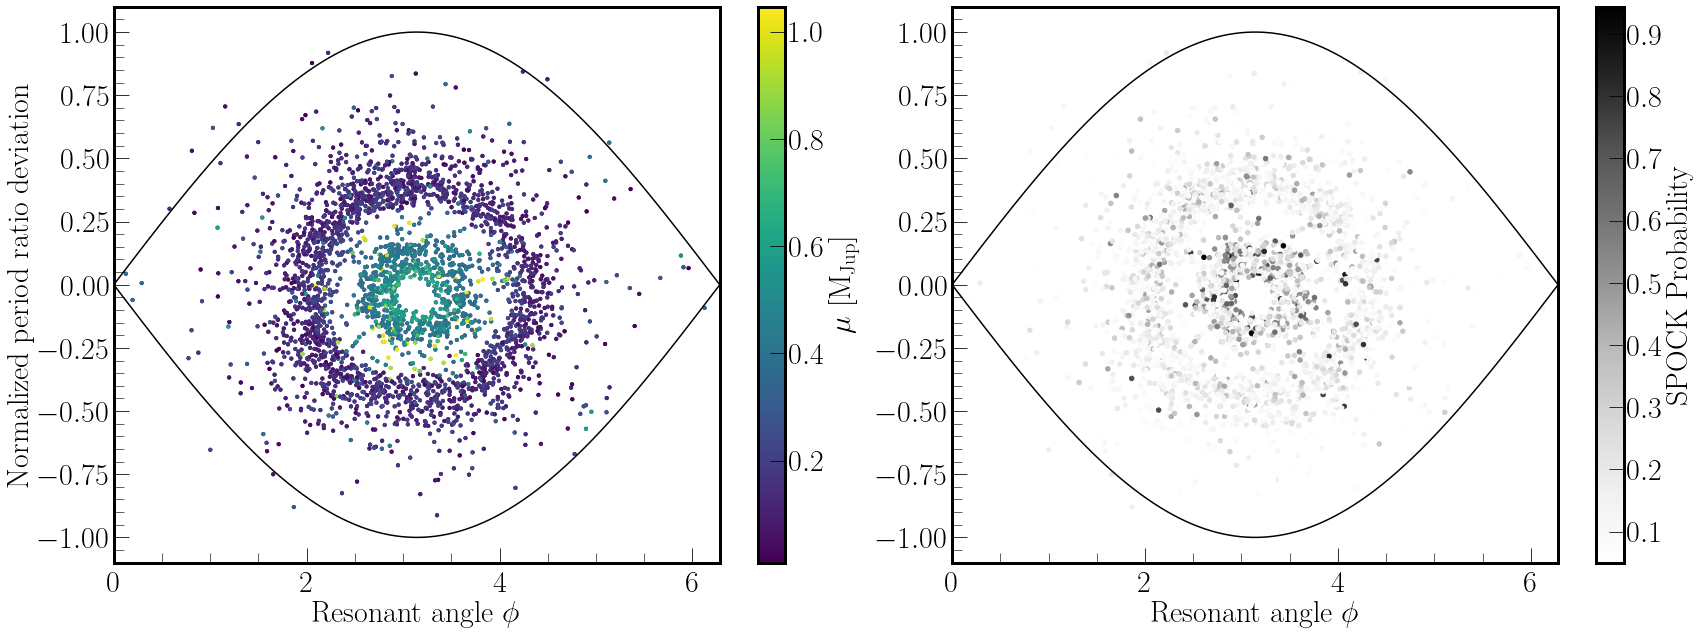

In [201]:
fig = plt.figure(1,figsize=(7*3.4, 3.5*3.4*3/4.))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

phis = np.linspace(0, 2*np.pi, 1000)
sep_upper = np.sin(phis/2)
ax1.plot(phis, sep_upper, 'k')
ax1.plot(phis, -sep_upper, 'k')
ax1.set_xlim([0,2*np.pi])
ax1.set_xlabel('Resonant angle $\phi$',fontsize=30)
ax1.set_ylabel('Normalized period ratio deviation',fontsize=30)
#cb = ax.scatter(phi, Phinorm, c=spock_prob, alpha=spock_prob, s=20)

cb=ax1.scatter(phi_rv[spock_inres_rv >= 0.05], Phinorm_rv[spock_inres_rv >= 0.05], 
              c=[(10**(param[2]))/9.54e-4 for param in rv_inres[spock_inres_rv >= 0.05]], 
              s=10)
ax1.scatter(phi_rv[spock_inres_rv >= 0.05], Phinorm_rv[spock_inres_rv >= 0.05], 
              c=[param[2] for param in rv_inres[spock_inres_rv >= 0.05]], 
              s=10)

cbar1 = fig.colorbar(cb, ax=ax1)
cbar1.set_label(r'$\mu$ [M$_{\rm{Jup}}$]', fontsize=30)
cbar1.ax.tick_params(labelsize=30)

ax2.plot(phis, sep_upper, 'k')
ax2.plot(phis, -sep_upper, 'k')
ax2.set_xlim([0,2*np.pi])
ax2.set_xlabel('Resonant angle $\phi$',fontsize=30)
#ax2.set_ylabel('Normalized period ratio deviation',fontsize=30)

cb2=ax2.scatter(phi_rv[spock_inres_rv >= 0.05], Phinorm_rv[spock_inres_rv >= 0.05], 
              c=[prob for prob in spock_inres_rv[spock_inres_rv >= 0.05]],cmap='Greys', 
              s=20) 

cbar2 = fig.colorbar(cb2, ax=ax2)
cbar2.set_label(r'SPOCK Probability', fontsize=30)
cbar2.ax.tick_params(labelsize=30)
#fig.colorbar(cb2, ax=ax2).set_label(r'SPOCK Probability', fontsize=30)

ax1.minorticks_on()
ax2.minorticks_on()

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)

ax2.tick_params(axis='y', labelsize=30)
ax2.tick_params(axis='x', labelsize=30)

plt.tight_layout()
plt.savefig('figures/Figure2.pdf',dpi=300,bbox_inches='tight',padding=0)

### Figure 3

In [202]:
mb_array = (10**np.array([rv_post[i][-2] for i in range(len(rv_post))]))/9.54e-4
eb_array = np.array([rv_post[i][-1] for i in range(len(rv_post))])

In [203]:
mb_array_logu = (10**np.array([logu_post[i][-2] for i in range(len(logu_post))]))/9.54e-4
eb_array_logu = np.array([logu_post[i][-1] for i in range(len(logu_post))])

In [204]:
#spock_prob_logu2 = preds_logu

In [205]:
#np.save('stability_posteriors/100k_logu_stability_preds.npy',spock_prob_logu2)

In [206]:
deltaH_db_logu2 = get_deltaH(logu_post,j=2, k=1, i1=2, i2=3)

0it [00:00, ?it/s]/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:52: UserWarning: k=1 resonance has no unstable fixed point for Phiprime < 1
  warnings.warn("k=1 resonance has no unstable fixed point for Phiprime < 1")
/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:91: UserWarning: There is no separatrix for the passed value of Phiprime
  warnings.warn("There is no separatrix for the passed value of Phiprime")
100000it [18:05, 92.13it/s]


In [209]:
np.save('stability_posteriors/deltaH_db_logu.npy',deltaH_db_logu2)

In [226]:
print(len(mb_array[spock_prob_rv > 0.0]))
print(len(mb_array_logu[spock_prob_logu > 0.0]))

29623
59496


In [216]:
print('Stable resonant:',len(mb_array[spock_prob_rv > 0.0][np.array(deltaH_db_rv2)[spock_prob_rv > 0.0] < 0]))
print('Stable non-resonant:',
      len(mb_array[spock_prob_rv > 0.0][np.array(deltaH_db_rv2)[spock_prob_rv > 0.0] >= 0]))

Stable resonant: 167
Stable non-resonant: 29456


In [217]:
print('Unstable resonant:',
      len(mb_array[spock_prob_rv == 0.0][np.array(deltaH_db_rv2)[spock_prob_rv == 0.0] < 0]))
print('Unstable non-resonant:',
      len(mb_array[spock_prob_rv == 0.0][np.array(deltaH_db_rv2)[spock_prob_rv == 0.0] >= 0]))

Unstable resonant: 6231
Unstable non-resonant: 64146


In [218]:
print('Stable resonant:',
      len(mb_array_logu[spock_prob_logu > 0.0][np.array(deltaH_db_logu2)[spock_prob_logu > 0.0] < 0]))
print('Stable non-resonant:',
      len(mb_array_logu[spock_prob_logu > 0.0][(np.array(deltaH_db_logu2)[spock_prob_logu > 0.0] >= 0)]))
print('\n')
print('Unstable resonant:',
      len(mb_array_logu[spock_prob_logu == 0.0][np.array(deltaH_db_logu2)[spock_prob_logu == 0.0] < 0]))
print('Unstable non-resonant:',
      len(mb_array_logu[spock_prob_logu == 0.0][np.array(deltaH_db_logu2)[spock_prob_logu == 0.0] >= 0]))

Stable resonant: 136
Stable non-resonant: 59358


Unstable resonant: 13341
Unstable non-resonant: 24489


In [219]:
three_sigma = [float(DescrStatsW(data=np.array(rv_post)[:,i], 
                         weights=spock_prob_rv).quantile(probs=np.array([0.997]), 
                                                 return_pandas=False)) for i in range(np.shape(rv_post)[1])]

In [222]:
(10**three_sigma[-2])/9.54e-4

1.06214123194921

In [224]:
three_sigma[-1]

0.1827834918753552

<ipython-input-225-b79b838199fb>:96: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/Figure3.pdf',dpi=300,bbox_inches='tight',padding=0)


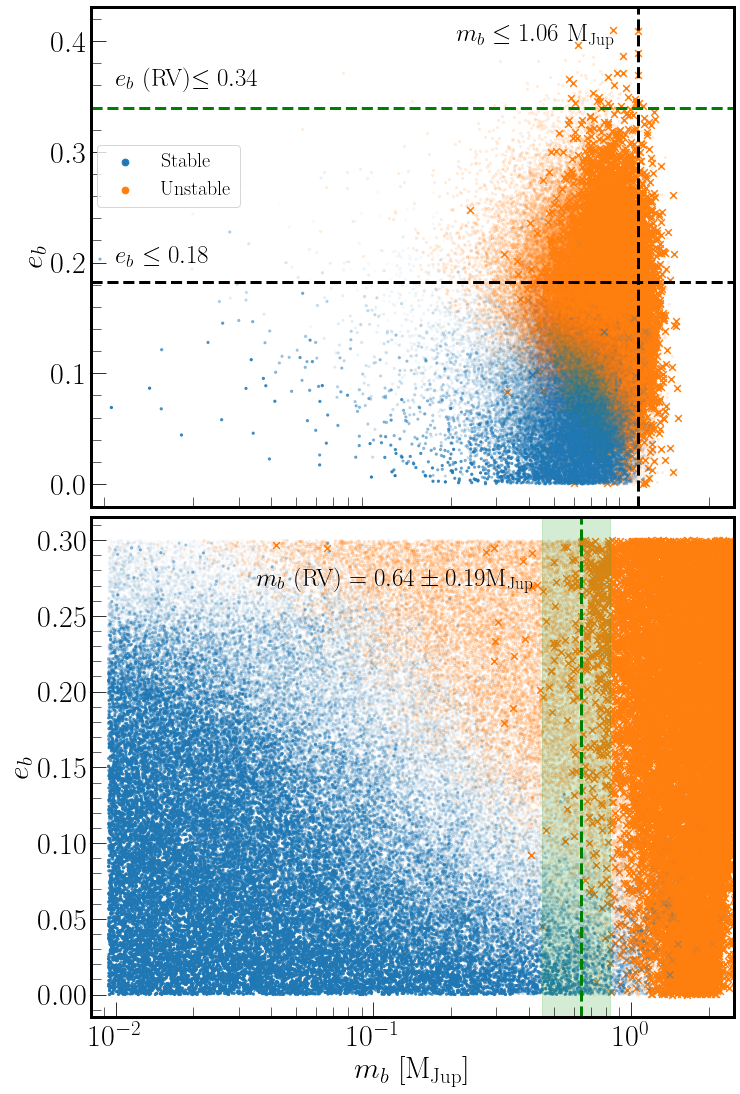

In [225]:
fig = plt.figure(1,figsize=(3*3.4, 6*3.4*3/4.))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
#ax3 = fig.add_subplot(223)
#ax4 = fig.add_subplot(224)

size = 30

# stable, in MMR
ax1.scatter(mb_array[spock_prob_rv > 0.0][np.array(deltaH_db_rv2)[spock_prob_rv > 0.0] < 0],
            eb_array[spock_prob_rv > 0.0][np.array(deltaH_db_rv2)[spock_prob_rv > 0.0] < 0],
            alpha=spock_prob_rv2[spock_prob_rv2 > 0.0][np.array(deltaH_db_rv2)[spock_prob_rv2 > 0.0] < 0],
            c='C0',marker='x',s=45,zorder=1, rasterized=True)

# stable, out of MMR
ax1.scatter(mb_array[spock_prob_rv > 0.0][(np.array(deltaH_db_rv2)[spock_prob_rv > 0.0] >= 0) \
                                           | np.isnan(deltaH_db_rv2)[spock_prob_rv > 0.0]],
            eb_array[spock_prob_rv > 0.0][(np.array(deltaH_db_rv2)[spock_prob_rv > 0.0] >= 0) \
                                           | np.isnan(deltaH_db_rv2)[spock_prob_rv > 0.0]],
            alpha=spock_prob_rv[spock_prob_rv > 0.0][np.array(deltaH_db_rv2)[spock_prob_rv > 0.0] >= 0],
            c='C0',marker='o',s=5,zorder=1,label='Stable', rasterized=True)

# unstable, in MMR
ax1.scatter(mb_array[spock_prob_rv == 0.0][(np.array(deltaH_db_rv2)[spock_prob_rv == 0.0] < 0) \
                                           | np.isnan(deltaH_db_rv2)[spock_prob_rv == 0.0]],
            eb_array[spock_prob_rv == 0.0][(np.array(deltaH_db_rv2)[spock_prob_rv == 0.0] < 0) \
                                           | np.isnan(deltaH_db_rv2)[spock_prob_rv == 0.0]], 
            alpha=1.0,c='C1',marker='x',s=45,zorder=0, rasterized=True)

# unstable, out of MMR
ax1.scatter(mb_array[spock_prob_rv == 0.0][np.array(deltaH_db_rv2)[spock_prob_rv == 0.0] >= 0],
            eb_array[spock_prob_rv == 0.0][np.array(deltaH_db_rv2)[spock_prob_rv == 0.0] >= 0], 
            alpha=0.1,c='C1',s=5,marker='o',zorder=0,label='Unstable', rasterized=True)

ax1.axvline(x=(10**three_sigma[-2])/9.54e-4, ls='--', color='k', lw=3)
#ax1.axvline(x=1.21, ls='--', color='g', lw=3)
ax1.axhline(y=three_sigma[-1], ls='--', color='k', lw=3)
ax1.axhline(y=0.34, ls='--', color='g', lw=3)

ax1.set_ylabel('$e_b$',fontsize=size)
ax1.set_xscale('log')
ax1.minorticks_on()

##### log-uniform 

ax2.scatter(mb_array_logu[spock_prob_logu > 0.0][np.array(deltaH_db_logu2)[spock_prob_logu > 0.0] < 0],
            eb_array_logu[spock_prob_logu > 0.0][np.array(deltaH_db_logu2)[spock_prob_logu > 0.0] < 0],
      alpha=spock_prob_logu[spock_prob_logu > 0.0][np.array(deltaH_db_logu2)[spock_prob_logu > 0.0] < 0],
            c='C0',marker='x',s=45,zorder=1, rasterized=True)

ax2.scatter(mb_array_logu[spock_prob_logu > 0.0][np.array(deltaH_db_logu2)[spock_prob_logu > 0.0] >= 0],
            eb_array_logu[spock_prob_logu > 0.0][np.array(deltaH_db_logu2)[spock_prob_logu > 0.0] >= 0],
      alpha=spock_prob_logu[spock_prob_logu > 0.0][np.array(deltaH_db_logu2)[spock_prob_logu > 0.0] >= 0],
            c='C0',marker='o',s=5,zorder=1)

ax2.scatter(mb_array_logu[spock_prob_logu == 0.0][np.array(deltaH_db_logu2)[spock_prob_logu == 0.0] < 0],
            eb_array_logu[spock_prob_logu == 0.0][np.array(deltaH_db_logu2)[spock_prob_logu == 0.0] < 0], 
            alpha=1.0,c='C1',marker='x',s=45,zorder=0, rasterized=True)

ax2.scatter(mb_array_logu[spock_prob_logu == 0.0][np.array(deltaH_db_logu2)[spock_prob_logu == 0.0] >= 0],
            eb_array_logu[spock_prob_logu == 0.0][np.array(deltaH_db_logu2)[spock_prob_logu == 0.0] >= 0], 
            alpha=0.1,c='C1',s=5,marker='o',zorder=0, rasterized=True)

ax2.axvline(x=0.64, ls='--', color='g', lw=3)
ax2.axvspan(0.64-0.19,0.64+0.19, alpha=0.2, color='C2')

ax2.set_xlabel('$m_b$ [$\\rm{M}_{\\rm{Jup}}]$',fontsize=size,zorder=0)
ax2.set_ylabel('$e_b$',fontsize=size)
ax2.set_xscale('log')
ax2.minorticks_on()

ax1.set_xlim(8e-3, 2.5)
ax2.set_xlim(8e-3, 2.5)
ax1.set_xticks([])
#ax2.set_xticks([])
#ax2.set_yticks([])

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)

ax2.tick_params(axis='y', labelsize=30)
ax2.tick_params(axis='x', labelsize=30)

leg1 = ax1.legend(prop={'size':20}, loc=(0.01, 0.6))
for lh in leg1.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [45]

    
ax1.text(0.21,0.40,r'$m_b \leq {}$'.format(1.06)+' $\\rm{M}_{\\rm{Jup}}$',dict(size=25))
ax2.text(0.035,0.27,r'$m_b\ (\rm{RV}) = 0.64 \pm 0.19$' + '$\\rm{M}_{\\rm{Jup}}$',dict(size=25))
ax1.text(0.01,0.20,r'$e_b$' + "~$\leq {}$".format(0.18),dict(size=25))
ax1.text(0.01,0.36,r'$e_b$' +"~(RV)" + '$\leq {}$'.format(0.34),dict(size=25))
plt.tight_layout()

plt.savefig('figures/Figure3.pdf',dpi=300,bbox_inches='tight',padding=0)

plt.show()

### Period ratio plots

1000it [00:16, 59.12it/s]
<ipython-input-389-126b9fbaf6cd>:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/Figure2b.pdf',dpi=300,bbox_inches='tight',padding=0)


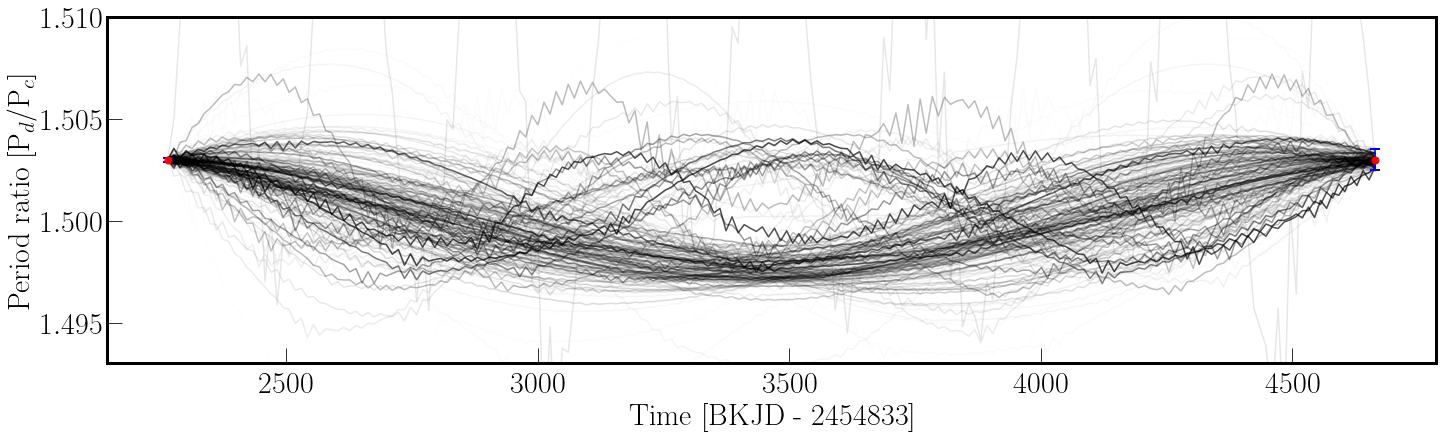

In [389]:
fig = plt.figure(1,figsize=(7*3.4, 2.5*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

for i,param in tqdm(enumerate(rv_inres_deltaT[:1000])):
    p = param
    
    sim = makesim(p)
    #pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
    
    #sim.add(m=10**param[-2], P=sim.particles[2].P*1.946, e=param[-1], pomega=pomega_b, theta=np.pi/2)
    period_ratios = run(sim)
    
    ax.plot(time_grid,period_ratios,
         alpha=spock_inres_rv[i],zorder=0, c='k',
         rasterized=True)

#ax1.plot(time_grid, run(makesim(min_mu[0][:4])), c='C2')

ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=7, c='r',ecolor='b',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_d$/P$_c$]',fontsize=30)
ax.set_ylim(1.493, 1.510)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=30)

ax.tick_params(axis='y', labelsize=30)
ax.tick_params(axis='x', labelsize=30)
plt.savefig('figures/Figure2b.pdf',dpi=300,bbox_inches='tight',padding=0)

100it [00:01, 56.48it/s]


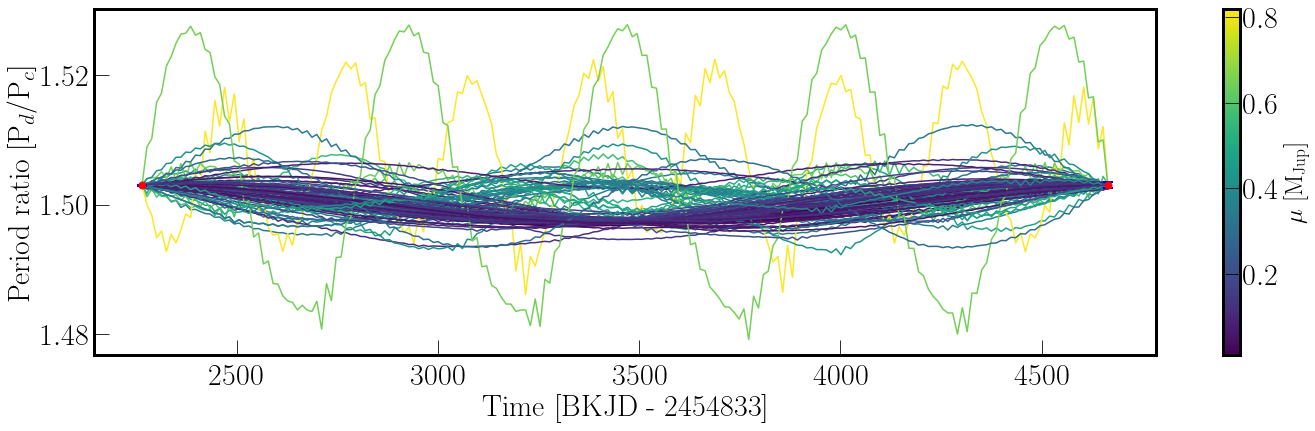

In [439]:
fig = plt.figure(1,figsize=(7*3.4, 2.5*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

size=100

c_mu = np.array([param[-2] for param in rv_inres_deltaT[:size]])
c_mu2 = np.array([(10**param[-2])/9.54e-4 for param in rv_inres_deltaT[:size]])
norm = mpl.colors.Normalize(vmin=c_mu.min(), vmax=c_mu.max())
norm2 = mpl.colors.Normalize(vmin=c_mu2.min(), vmax=c_mu2.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)
cmap2 = mpl.cm.ScalarMappable(norm=norm2, cmap=mpl.cm.viridis)
cmap.set_array([])
cmap2.set_array([])

for i,param in tqdm(enumerate(rv_inres_deltaT[:size])):
    p = param
    
    sim = makesim(p)
    #pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
    
    #sim.add(m=10**param[-2], P=sim.particles[2].P*1.946, e=param[-1], pomega=pomega_b, theta=np.pi/2)
    period_ratios = run(sim)
    
    #cb_pratio = ax.plot(time_grid,period_ratios,
    #     alpha=1.0,zorder=0, c=cmap.to_rgba((10**c_mu[i])/9.54e-4),
    #     rasterized=True)
    ax.plot(time_grid,period_ratios,
         alpha=1.0,zorder=0, c=cmap.to_rgba(c_mu[i]),
         rasterized=True)
    



#ax1.plot(time_grid, run(makesim(min_mu[0][:4])), c='C2')

ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=7, c='r',ecolor='b',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_d$/P$_c$]',fontsize=30)
#ax.set_ylim(1.493, 1.510)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=30)

ax.tick_params(axis='y', labelsize=30)
ax.tick_params(axis='x', labelsize=30)

t_cbar = fig.colorbar(cmap2)
t_cbar.set_label(r'$\mu$ [M$_{\rm{Jup}}$]', fontsize=25)
t_cbar.ax.tick_params(labelsize=30)
plt.show()
#plt.savefig('figures/Figure2b.pdf',dpi=300,bbox_inches='tight',padding=0)

## Prior sensitivity tests: Lowering the mass of planet b in log uniform sampling to see how much it changes

### Original limits (3 $M_\oplus$, 3 $M_\rm{Jup}$)

In [14]:
Nsamps = 25000

In [15]:
simlist_logu, indices_logu = sampler(Nsamps, like_output, e_b=True)

100%|██████████| 25000/25000 [03:01<00:00, 137.48it/s]


In [16]:
s_results_logu, preds_logu, sigma_list_logu = weighted_results(simlist_logu, indices_logu, 0.95, 
                                                               like_output, ecc_b=True)

In [27]:
sigma_list_logu = [float(DescrStatsW(data=np.array(s_results_logu)[:,i], 
                         weights=preds_logu).quantile(probs=np.array([0.997]), 
                                                 return_pandas=False)) for i in range(np.shape(s_results_logu)[1])]

In [29]:
sigma_list_logu[2]

-3.1940014423446743

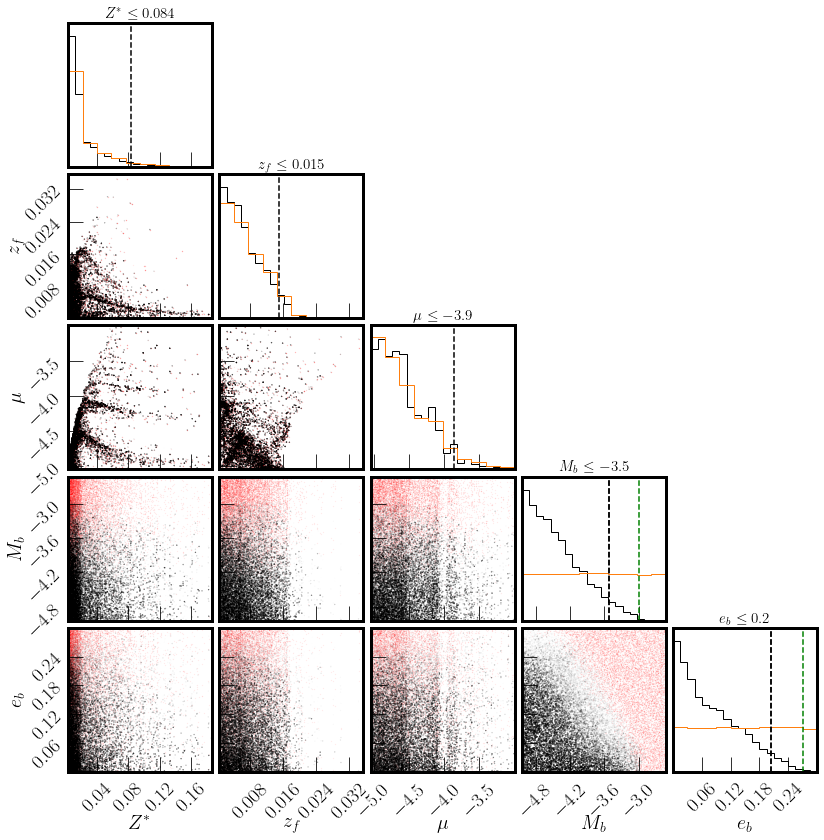

In [17]:
corner_plot(s_results_logu, preds_logu, sigma_list_logu, pl_b=True, ecc_b=True,
            labels=["$Z^*$", "$z_f$", "$\mu$", "$M_b$", "$e_b$"], 
           )

### Changed limits (0.1 $M_\oplus$, 3 $M_\rm{Jup}$)

In [19]:
simlist_logu2, indices_logu2 = sampler(Nsamps, like_output, bmass_lims=[3.00273e-7, 3e-3],e_b=True)

100%|██████████| 25000/25000 [03:02<00:00, 136.77it/s]


In [20]:
s_results_logu2, preds_logu2, sigma_list_logu2 = weighted_results(simlist_logu2, indices_logu2, 0.95, 
                                                               like_output, ecc_b=True)

In [30]:
sigma_list_logu2 = [float(DescrStatsW(data=np.array(s_results_logu2)[:,i], 
                         weights=preds_logu2).quantile(probs=np.array([0.997]), 
                                                 return_pandas=False)) for i in range(np.shape(s_results_logu2)[1])]

In [31]:
sigma_list_logu2[2]

-3.30032361251335

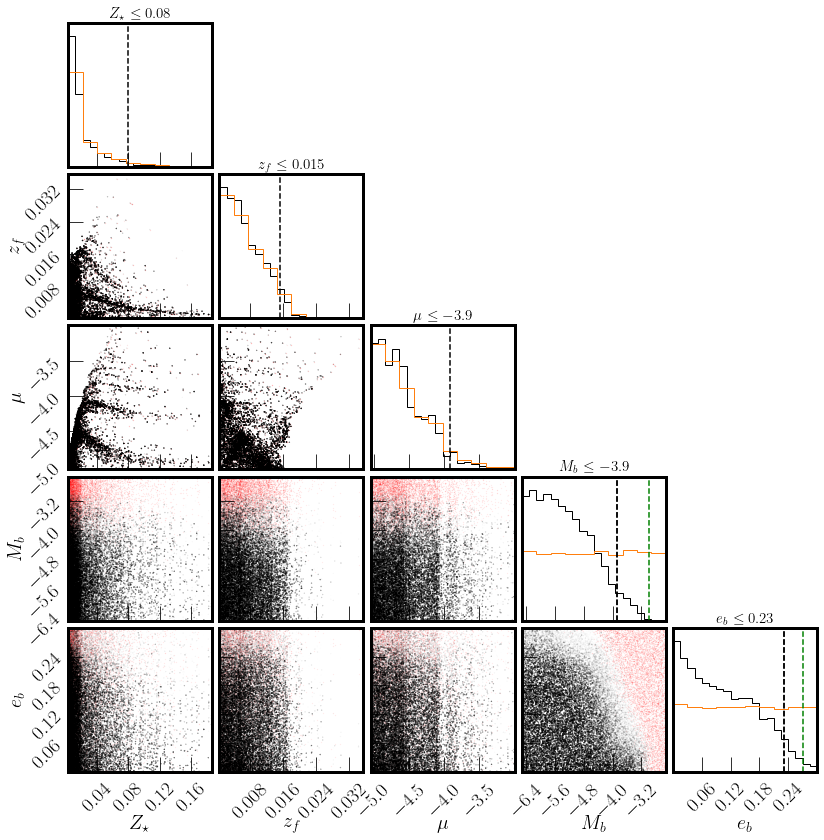

In [22]:
corner_plot(s_results_logu2, preds_logu2, sigma_list_logu2, pl_b=True, ecc_b=True,
            labels=["$Z_\star$", "$z_f$", "$\mu$", "$M_b$", "$e_b$"], 
           )

### Changed limits (3 $M_\oplus$, 10 $M_\rm{Jup}$)

In [23]:
simlist_logu3, indices_logu3 = sampler(Nsamps, like_output, bmass_lims=[8.964e-6, 3e-2],e_b=True)

100%|██████████| 25000/25000 [03:02<00:00, 136.89it/s]


In [24]:
s_results_logu3, preds_logu3, sigma_list_logu3 = weighted_results(simlist_logu3, indices_logu3, 0.95, 
                                                               like_output, ecc_b=True)

In [32]:
sigma_list_logu3 = [float(DescrStatsW(data=np.array(s_results_logu3)[:,i], 
                         weights=preds_logu3).quantile(probs=np.array([0.997]), 
                                                 return_pandas=False)) for i in range(np.shape(s_results_logu3)[1])]

In [33]:
sigma_list_logu3[2]

-3.193458933940142

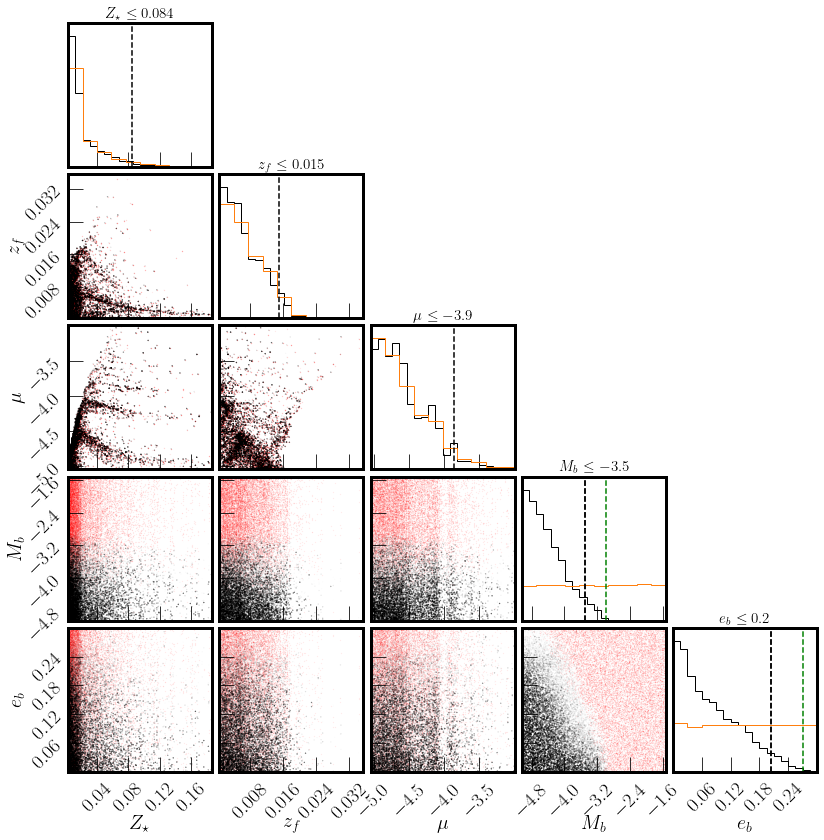

In [25]:
corner_plot(s_results_logu3, preds_logu3, sigma_list_logu3, pl_b=True, ecc_b=True,
            labels=["$Z_\star$", "$z_f$", "$\mu$", "$M_b$", "$e_b$"], 
           )

# Getting estimates on the upper bounds by bootstrap method from Miles

In [129]:
# using the random module because np.random.choice doesn't have a weights option

from random import choices

In [130]:
def bootstrap(samp_array, probs, percentile):
    all_measurements = []
    for _ in range(100):
        #data_idx = np.arange(samp_array.shape[0])
        chosen_samples = choices(samp_array, k=samp_array.shape[0], weights=probs)
        current_measurement = np.percentile(chosen_samples, percentile)
        all_measurements.append(current_measurement)

    mean_estimate_for_upper_limit = np.average(all_measurements)
    uncertainty_on_upper_limit = np.std(all_measurements)
    
    return mean_estimate_for_upper_limit, uncertainty_on_upper_limit

In [140]:
mb_test = np.array([param[-2] for param in rv_inres])
eb_test = np.array([param[-1] for param in rv_inres])

mean, std = bootstrap((10**mb_test)/9.54e-4, spock_inres_rv, 97.5)

print('m_b:',mean, std)

mean, std = bootstrap(eb_test, spock_inres_rv, 97.5)

print('e_b:', mean, std)

m_b: 0.9084572188289125 0.004879547119286804
e_b: 0.14134997606667338 0.0012819223258576725


In [141]:
mb_test = np.array([param[-2] for param in rv_outres])
eb_test = np.array([param[-1] for param in rv_outres])

mean, std = bootstrap((10**mb_test)/9.54e-4, spock_outres_rv, 97.5)

print('m_b:', mean, std)

mean, std = bootstrap(eb_test, spock_outres_rv, 97.5)

print('e_b:', mean, std)

m_b: 0.9340160137344471 0.001992117286556814
e_b: 0.1314849824105234 0.00031764302763506757
